In [6]:
#The main file for case 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Path to main file
file_Moa = "/Users/moasjoberg/Documents/Turbulence_cource/Turbulence_course/FALL2_2.TXT"
# path to file for Groundflux
file_G = "/Users/moasjoberg/Documents/Turbulence_cource/Turbulence_course/Ground heat flux.txt"
# File for r_a
file_ra = "/Users/moasjoberg/Documents/Turbulence_cource/Turbulence_course/aerodynamic resistance.txt"


# Read as space-separated values
df = pd.read_csv(file_Moa, delim_whitespace=True, header=None)
df_G= pd.read_csv(file_G, delim_whitespace=True, header=None)



#retrieve variables
R = df.iloc[:, 22].to_numpy()  # Nettradiationn in column 23
#G= df.iloc[:, 17:23 ] # GROUND HEAT FLUX AT EACH HEGHT in column 18-22 (22 INCLUDED)
G = df_G[0].to_numpy()
p=df.iloc[:, 7].to_numpy()  # air pressure
theta= df.iloc[:, 5].to_numpy()  # Potential temperature at height
r= df.iloc[:,6].to_numpy() #relative humidity at height 2
u= df.iloc[:,5 ] #windspeed at height 10.1m 

#Constants
rho =  1.225 # kg/m³ - density of air at sea level (is it always the same?)
c_p= 1005 # J/(kg·K) specific heat of air at sea level
gamma= 0.066 # kPa °C - psycometric constant γ=cp⋅P/ (ε⋅λ)  (lambda is latent heat of vaporization, epsilon molecular weight of water vapor to dry air)
r_l = 100 #s m^-1 stomatal resistance of single leaf (well watered condition)
LAI= 4 # Mais crop 60 days after sowing (140 is harvest)
LAI_active= 0.5 * LAI
r_s = r_l/LAI_active # 
karman= 0.41




In [ ]:
# help functions

def pottemp_to_temp(theta):
    T=theta * 1**0.286
    return T


# we calculate difference e_s-e_a
def vapour_pressure_deficit(T): 
    e_s= 6.112 * np.exp(17.63 * T / (243.12 +T)) #Tetens equation
    T_min=np.min(T)
    e_a= r / 100 * e_s       #e_s(T_min)
    return e_s-e_a

# slope of the saturation curve
def gradient_e_s (e_s,T): 
    delta=e_s * 17.63 * T / (243.12 + T)**2
    return delta

# Calculate r_a
def resitance_aero(z_m,z_h, d, z_0m,z_0h, u):
    r_a= (np.log((z_m - d)/z_0m) * np.log((z_h - d)/z_0h)) / (karman**2 * u)
    return r_a

    

SyntaxError: invalid syntax (3733140661.py, line 22)

In [4]:
# Temperature at level z_1
T = pottemp_to_temp(theta)
e_s= 6.112 * np.exp(17.63 * T/ (243.12 +T)) #Tetens equation
e_sa= vapour_pressure_deficit(T) # use temperature at the lowest level to find water vapor deficit
delta= gradient_e_s(e_s, T)





In [ ]:
# Penman eq

ET= delta * (R-G) + rho * c_p * e_sa/r_a  / ( delta + gamma * (1 + r_s/ r_a) )



NameError: name 'r_a' is not defined

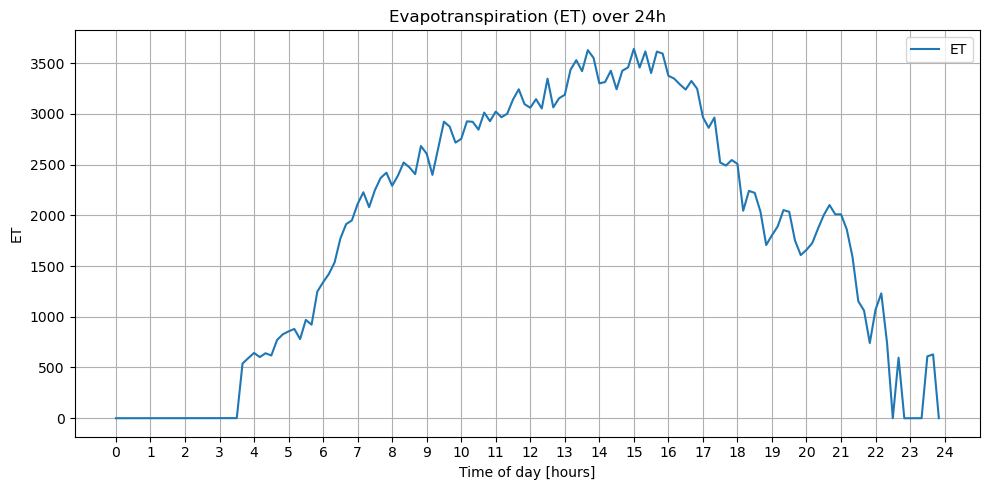

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Continuous time axis in hours (0–24 in 10 min steps)
time_hours = np.arange(0, 24, 10/60)   # 144 points

plt.figure(figsize=(10,5))
plt.plot(time_hours, ET, label="ET")
plt.xlabel("Time of day [hours]")
plt.ylabel("ET")
plt.title("Evapotranspiration (ET) over 24h")
plt.grid(True)

# Show ticks every hour
plt.xticks(range(0, 25, 1))

plt.legend()
plt.tight_layout()
plt.show()